# SPEAKER IDENTIFICATION
GMM on Librispeech

In [1]:
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import python_speech_features as mfcc

import _pickle as cPickle

from scipy.io.wavfile import read
from sklearn import mixture
import soundfile
import time

import warnings

import os
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import pickle

In [2]:
def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""
 
    # determines the number of rows and columns in the input array
    rows,cols = array.shape
    # create an array of zeros with the same number of rows as the input array and 20 columns
    deltas = np.zeros((rows,20))
    
    #Define window size
    N = 2
    
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first =0
            else:    
                first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas
 
def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines
    delta to make it 40 dim feature vector"""   
    
    #use the "mfcc" function of the "python_speech_features" module to extract 20-dimensional MFCC features from the audio file.
    mfcc_feat = mfcc.mfcc(audio,rate, 0.01, 0.01,20,appendEnergy = True, nfft=1024)
    
    #apply standard scaling to the MFCC features
    mfcc_feat = preprocessing.scale(mfcc_feat)
    
    #calculate the delta values for the MFCC features 
    delta = calculate_delta(mfcc_feat)    #The delta values represent the rate of change of the MFCC features over time and can be used to capture the dynamic aspects of the audio signal.
    
    #combines the MFCC and delta features by horizontally stacking them
    combined = np.hstack((mfcc_feat,delta))
    
    #return a feature vector with 40 dimensions
    return combined  

# Training Speaker Models

In [3]:
start_time = time.time()

warnings.filterwarnings("ignore")

#path to training data
source   = "NEW_Librispeech_SUBSET/"  #main folder dataset
 
#path where training speakers will be saved
dest = "speaker_models_dataset2_70\\"

#File with the name of files to be used for trainning
train_file = "Librispeech_train70.csv"
file_paths = open(train_file,'r') # reading audio files
 
count = 1

# Extracting features for each speaker
features = np.asarray(())
for path in file_paths:
    path = path.strip()
    #print(path)
 
    # read the audio
    audio, sr = soundfile.read(source + path)
 
    # extract 40 dimensional MFCC & delta MFCC features
    vector = extract_features(audio,sr)
 
    if features.size == 0:
        features = vector
    else:
        features = np.vstack((features, vector))
    # when features of 70 files of speaker are concatenated, then do model training
    if count == 70:
        
        gmm = mixture.GaussianMixture(n_components = 16, max_iter = 200, covariance_type='diag',n_init = 3)
        gmm.fit(features)
 
        # dumping the trained gaussian model
        picklefile = path.split("-")[0]+".gmm"
        #print(gmm)
        cPickle.dump(gmm,open(dest + picklefile,'wb'))
        print ('+ modeling completed for speaker:',picklefile," with data point = ",features.shape)
        features = np.asarray(())
        count = 0
    count = count + 1
    
end_time = time.time()
elapsed_time = end_time - start_time

print(f"The training took {elapsed_time:.2f} seconds to run.")

+ modeling completed for speaker: 19.gmm  with data point =  (96281, 40)
+ modeling completed for speaker: 26.gmm  with data point =  (85632, 40)
+ modeling completed for speaker: 27.gmm  with data point =  (59995, 40)
+ modeling completed for speaker: 32.gmm  with data point =  (89675, 40)
+ modeling completed for speaker: 40.gmm  with data point =  (88637, 40)
+ modeling completed for speaker: 78.gmm  with data point =  (90799, 40)
+ modeling completed for speaker: 83.gmm  with data point =  (84976, 40)
+ modeling completed for speaker: 87.gmm  with data point =  (98152, 40)
+ modeling completed for speaker: 89.gmm  with data point =  (86605, 40)
+ modeling completed for speaker: 103.gmm  with data point =  (97971, 40)
+ modeling completed for speaker: 118.gmm  with data point =  (78984, 40)
+ modeling completed for speaker: 125.gmm  with data point =  (78884, 40)
+ modeling completed for speaker: 150.gmm  with data point =  (93948, 40)
+ modeling completed for speaker: 163.gmm  with

# Evaluating Performance on test set

In [4]:
# Path to the directory containing the test audio files
test_dir = "NEW_Librispeech_SUBSET/"

# Path to the directory containing the trained GMM models
model_dir = "speaker_models_dataset2_70/"

# File containing the list of test audio files
test_file = "Librispeech_train70.csv"

# Load the trained GMM models and their corresponding speaker IDs
gmm_models = []
speaker_ids = []
for fname in os.listdir(model_dir):
    if fname.endswith('.gmm'):
        with open(os.path.join(model_dir, fname), 'rb') as f:
            gmm_models.append(pickle.load(f))
            speaker_ids.append(fname.split(".gmm")[0])

# Initialize lists to store the predicted speaker IDs, the second predicted speaker IDs, 
# the correct speaker IDs, and the log-likelihood scores
predicted_speakers = []
second_predicted_speakers = []
correct_speakers = []
winner_scores = []
second_scores = []

# Read the list of test audio files from the CSV file
with open(test_file, 'r') as f:
    test_files = f.readlines()

# Loop through each test audio file
for path in test_files:
    path = path.strip()
    speaker_id = path.partition("-")[0]
    #correct_speaker_idx = speaker_ids.index(speaker_id)

    # Read the audio file and extract its features
    audio, sr = soundfile.read(os.path.join(test_dir, path))
    features = extract_features(audio, sr)

    # Calculate the log-likelihood of the audio file given each GMM model
    log_likelihoods = np.zeros(len(gmm_models))
    for i, gmm_model in enumerate(gmm_models):
        log_likelihoods[i] = np.sum(gmm_model.score(features))

    # Predict the speaker ID with the highest log-likelihood score
    predicted_speaker_idx = np.argmax(log_likelihoods)
    predicted_speaker = speaker_ids[predicted_speaker_idx]
    predicted_speakers.append(predicted_speaker)

    # Predict the second highest speaker ID and store its log-likelihood score
    second_predicted_speaker_idx = np.argsort(log_likelihoods)[-2]
    second_predicted_speaker = speaker_ids[second_predicted_speaker_idx]
    second_predicted_speakers.append(second_predicted_speaker)

    # Store the correct speaker ID and the log-likelihood score for the predicted speaker
    correct_speakers.append(speaker_id)
    winner_scores.append(log_likelihoods[predicted_speaker_idx])
    second_scores.append(log_likelihoods[second_predicted_speaker_idx])
    
    #print(f"correct :{speaker_id}, winner: { predicted_speaker}, second: {second_predicted_speaker}")

# Calculate the elapsed time and print it
elapsed_time = time.time() - start_time
print(f"The testing took {elapsed_time:.2f} seconds to run.")



The testing took 5201.02 seconds to run.


In [5]:
# Create a DataFrame to hold the results
df = pd.DataFrame({'Speaker Real': correct_speakers,
                   'Speaker Predicted': predicted_speakers,
                   'Winner Score': winner_scores,
                   'Second Place': second_predicted_speakers,
                   'Second Place Score': second_scores})

# Save the DataFrame to an Excel file
df.to_excel('results_GMM_2.xlsx', index=False)

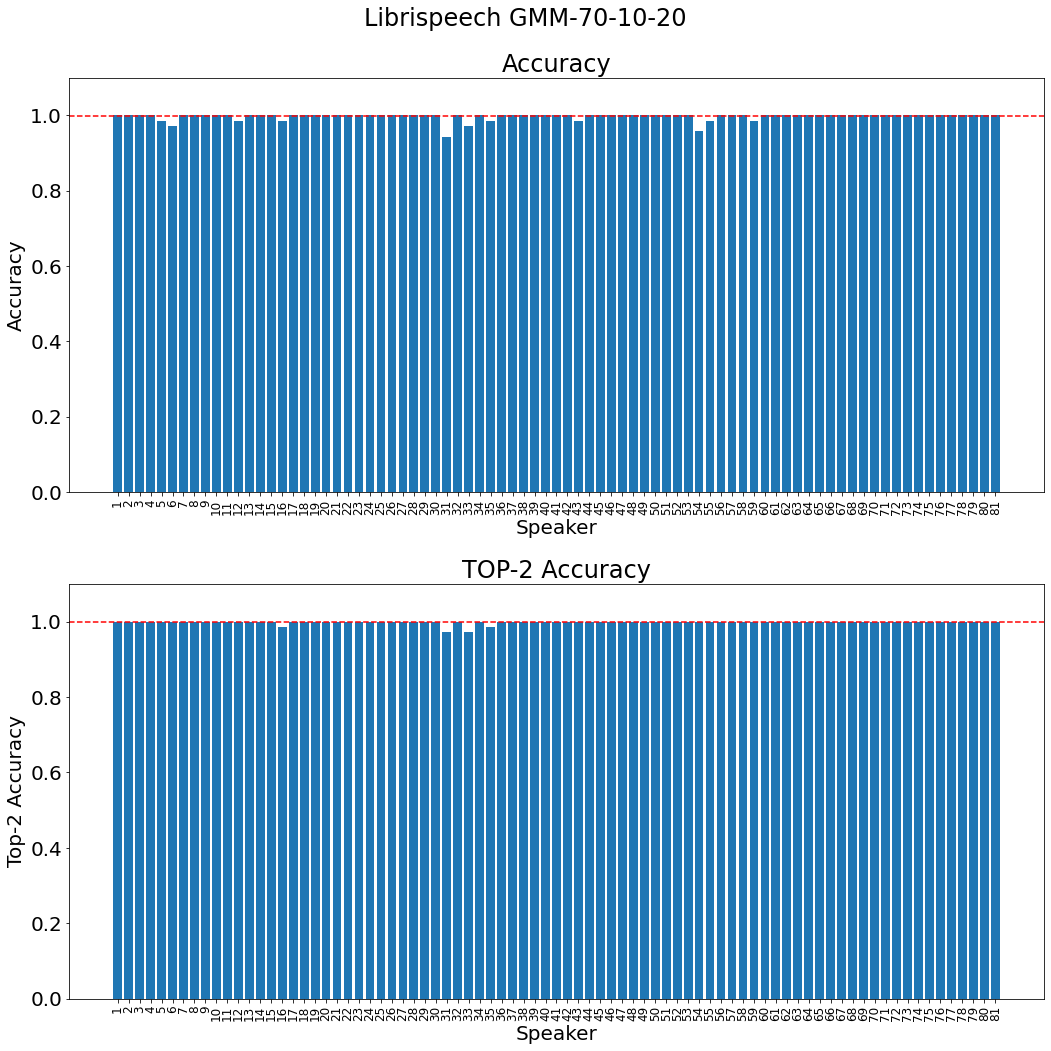

In [20]:
# Load the results DataFrame as df
results = df

plt.rcParams['font.size'] = 20

# Calculate accuracy for matching Test_y and Top_2_1
df["acc_1"] = (df['Speaker Real'] == df['Speaker Predicted'])

# Calculate accuracy for matching Test_y and (Top_2_1 & Top_2_2)
results["acc_2"]  = ((df['Speaker Real'] == df['Speaker Predicted']) | (df['Speaker Real'] == df['Second Place']))

# Get unique values of Test_y
unique_values = df['Speaker Real'].unique()

mean_accuracy = results.groupby(df['Speaker Real'])[['acc_1', 'acc_2']].mean().reset_index()
mean_accuracy.set_index(mean_accuracy.columns[0], inplace=True)

# Get the speaker names
speakers = mean_accuracy.index

# Create bar plots
fig, axs = plt.subplots(2, 1, figsize=(15, 15), facecolor='white')
plt.suptitle(f"Librispeech GMM-70-10-20")

axs[0].bar(range(len(speakers)), mean_accuracy['acc_1'])
axs[0].axhline(mean_accuracy['acc_1'].mean(), color='r', linestyle='--')
axs[0].set_xlabel('Speaker')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_xticks(range(len(speakers)))
axs[0].set_ylim([0,1.1])
axs[0].set_xticklabels(range(1, len(speakers) + 1), rotation=90, fontsize=12)

axs[1].bar(range(len(speakers)), mean_accuracy['acc_2'])
axs[1].axhline(mean_accuracy['acc_2'].mean(), color='r', linestyle='--')
axs[1].set_xlabel('Speaker')
axs[1].set_ylabel('Top-2 Accuracy')
axs[1].set_title('TOP-2 Accuracy')
axs[1].set_xticks(range(len(speakers)))
axs[1].set_ylim([0,1.1])
axs[1].set_xticklabels(range(1, len(speakers) + 1), rotation=90, fontsize=12)

#fig.suptitle(f"AudioMNIST_(TRAIN {100*train_size/data_size}%)", fontsize=26)
plt.tight_layout()


# Display the plot

plt.savefig("Librispeech_GMM-70-10-20.png")

In [7]:
mean_accuracy['acc_1'].mean()

0.9968253968253968

In [8]:
mean_accuracy['acc_2'].mean()

0.9989417989417989

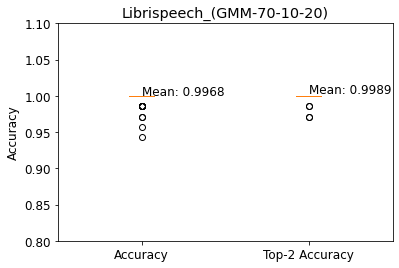

In [18]:
plt.rcParams['font.size'] = 12
# Create a figure and axis
fig, ax = plt.subplots(facecolor='white')

# Create a list of the two data series for box plots
data = [mean_accuracy['acc_1'], mean_accuracy['acc_2']]

# Create the box plots
box_plot = ax.boxplot(data, labels=['Accuracy', 'Top-2 Accuracy'])

# Add labels to the box plots
ax.set_ylabel('Accuracy')
ax.set_title("Librispeech_(GMM-70-10-20)")
ax.set_ylim([0.8, 1.1])

# Calculate the mean values
mean_values = [np.average(series) for series in data]

# Add mean labels
for i, mean in enumerate(mean_values):
    ax.text(i + 1, mean, f"Mean: {mean:.4f}", fontsize=12, va='bottom')


# Display the plot

plt.savefig("Librispeech_(GMM-70-10-20)_BP.png")

In [10]:
#Sumit // Accuracy =  total of true speakers / all speakers * 100

accuracy = len(set(correct_speakers).intersection(predicted_speakers)) / max(len(set(correct_speakers)),len(set(predicted_speakers))) * 100
print(f"\tAccuracy - {round(accuracy,2)}%")

	Accuracy - 100.0%
